In [1]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 11.4MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 12.8MB 218kB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101
  Found existing installation: torchvision 0.9.0+cu101
    Uninstalling torchvision-0.9.0+cu101:
      Successfully uninstalled torchvision-0.9.0+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 296kB 8.0MB/s 


In [2]:
!wget https://www.dropbox.com/s/qrdswgzv63o3opg/datasetCorregido.zip?dl=1 -O erm.zip

--2021-03-08 18:07:40--  https://www.dropbox.com/s/qrdswgzv63o3opg/datasetCorregido.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/qrdswgzv63o3opg/datasetCorregido.zip [following]
--2021-03-08 18:07:41--  https://www.dropbox.com/s/dl/qrdswgzv63o3opg/datasetCorregido.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbe2b024a50fc63e6cc56318b9e.dl.dropboxusercontent.com/cd/0/get/BKS5xugTcAH7vMqIqnQ-jdAzUIi4_0G4alekFCXJRJxCYdITSh924hzdC4j3G-hvVXBiS1HVhEV7fweq38yvky04tuivaNmKOi1d2X--A-CyPDOLOJr2i85oMj09rug3OarcfzK8ydvDj0KVMUxqM61c/file?dl=1# [following]
--2021-03-08 18:07:41--  https://ucbe2b024a50fc63e6cc56318b9e.dl.dropboxusercontent.com/cd/0/get/BKS5xugTcAH7vMqIqnQ-jdAzUIi4_0G4alekFCXJRJxCYdITSh924hzdC4j3G

In [3]:
!unzip erm.zip

Archive:  erm.zip
   creating: datasetCorregido/
   creating: datasetCorregido/train/
   creating: datasetCorregido/train/no/
  inflating: datasetCorregido/train/no/anonymized_482127.jpg  
  inflating: datasetCorregido/train/no/anonymized_174749.jpg  
  inflating: datasetCorregido/train/no/anonymized_734047.jpg  
  inflating: datasetCorregido/train/no/anonymized_581767.jpg  
  inflating: datasetCorregido/train/no/anonymized_1400777.jpg  
  inflating: datasetCorregido/train/no/anonymized_347431.jpg  
  inflating: datasetCorregido/train/no/anonymized_626433.jpg  
  inflating: datasetCorregido/train/no/anonymized_1372303.jpg  
  inflating: datasetCorregido/train/no/anonymized_1324599.jpg  
  inflating: datasetCorregido/train/no/anonymized_196853.jpg  
  inflating: datasetCorregido/train/no/anonymized_687000.jpg  
  inflating: datasetCorregido/train/no/anonymized_504041.jpg  
  inflating: datasetCorregido/train/no/anonymized_1414333.jpg  
  inflating: datasetCorregido/train/no/anonymized_3

In [4]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [5]:
path = Path('datasetCorregido/')
trainPath = path/'train'
testPath = path/'test'

In [6]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=360,max_warp=0,max_zoom=1.1,
                      max_lighting=0.1,p_lighting=0.5), Normalize.from_stats(*imagenet_stats)])

In [7]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=32)

In [8]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18')
]

In [9]:
modelo='mnasnet_050'

## Ranger

In [10]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [11]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

No pretrained weights exist for this model. Using random initialization.


SuggestedLRs(lr_min=0.07585775852203369, lr_steep=6.309573450380412e-07)

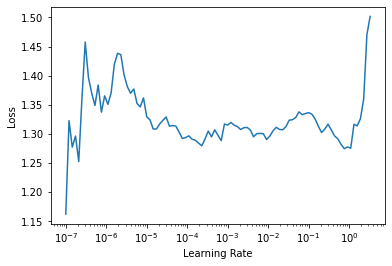

In [12]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.279883,0.968227,0.507645,0.494152,0.531447,00:32
1,1.235350,1.037193,0.481651,0.474576,0.616352,00:31


Better model found at epoch 0 with valid_loss value: 0.9682267308235168.


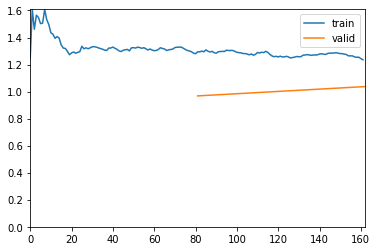

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.276336,0.986348,0.469419,0.456973,0.484277,00:35
1,1.286194,0.974625,0.501529,0.489247,0.572327,00:35
2,1.244604,1.007596,0.458716,0.449438,0.503145,00:35
3,1.255391,0.925961,0.498471,0.486559,0.569182,00:35
4,1.188649,0.909582,0.481651,0.472868,0.575472,00:35
5,1.217439,0.954689,0.487768,0.478697,0.600629,00:35
6,1.208723,0.898701,0.484709,0.475703,0.584906,00:35
7,1.195292,0.899830,0.490826,0.481203,0.603774,00:35
8,1.152362,0.902893,0.503058,0.492274,0.701258,00:35
9,1.108773,0.886268,0.477064,0.470443,0.600629,00:35


Better model found at epoch 0 with valid_loss value: 0.9863475561141968.


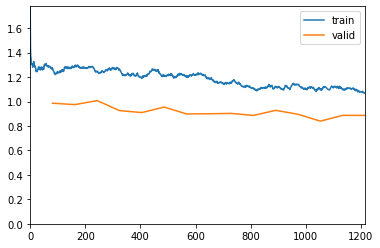

Better model found at epoch 1 with valid_loss value: 0.974624752998352.
Better model found at epoch 3 with valid_loss value: 0.9259606003761292.
Better model found at epoch 4 with valid_loss value: 0.9095815420150757.
Better model found at epoch 6 with valid_loss value: 0.8987009525299072.
Better model found at epoch 9 with valid_loss value: 0.8862676024436951.
Better model found at epoch 12 with valid_loss value: 0.8395500779151917.


In [13]:
learn.fine_tune(15,freeze_epochs=2)

In [14]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

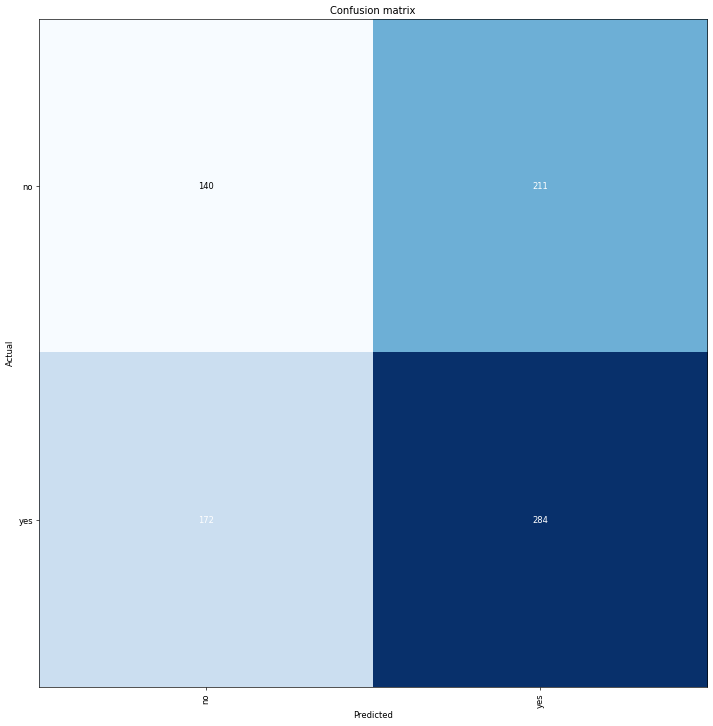

In [15]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [16]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5254027247428894.


(#4) [0.8221350908279419,0.5254027247428894,0.5737373737373738,0.6228070175438597]

## Faltten

In [17]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()])

No pretrained weights exist for this model. Using random initialization.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.147456,0.893951,0.495413,0.485507,0.632075,00:34
1,0.958527,0.787103,0.493884,0.483204,0.588050,00:34


Better model found at epoch 0 with valid_loss value: 0.8939507603645325.


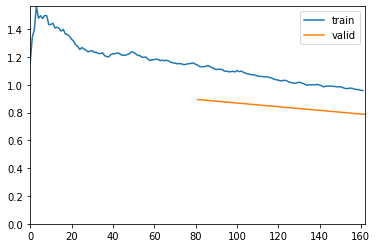

Better model found at epoch 1 with valid_loss value: 0.7871034145355225.


In [18]:
learn.fit_flat_cos(2,lr=1e-3)

In [19]:
learn.unfreeze()

SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=7.585775847473997e-07)

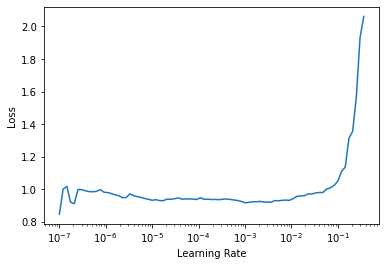

In [20]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.007894,1.869547,0.487768,0.486903,0.993711,00:36
1,1.012279,0.854357,0.542813,0.584071,0.207547,00:34
2,0.920449,1.424537,0.500000,0.426230,0.081761,00:36
3,0.966161,1.170711,0.486239,0.485714,0.962264,00:36
4,0.953041,38.501022,0.512232,0.494505,0.141509,00:36


Better model found at epoch 0 with valid_loss value: 1.8695470094680786.


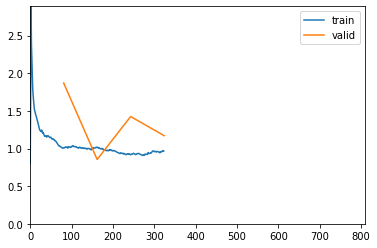

Better model found at epoch 1 with valid_loss value: 0.8543568849563599.
No improvement since epoch 1: early stopping


In [21]:
learn.fit_flat_cos(10,lr=1e-2)

In [22]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

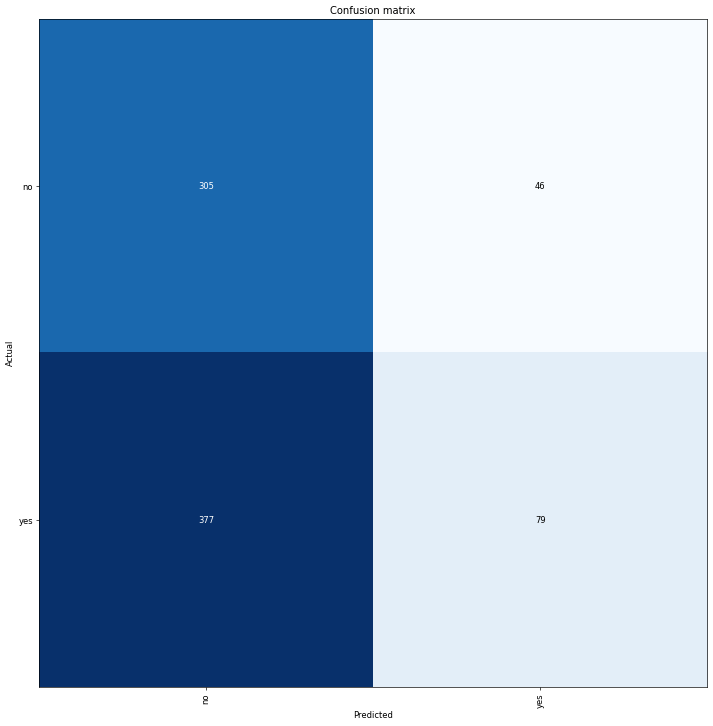

In [23]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [24]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.4758364260196686.


(#4) [0.9330093264579773,0.4758364260196686,0.632,0.17324561403508773]

## LabelSmoothing

In [25]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

No pretrained weights exist for this model. Using random initialization.


SuggestedLRs(lr_min=0.004786301031708717, lr_steep=1.3182567499825382e-06)

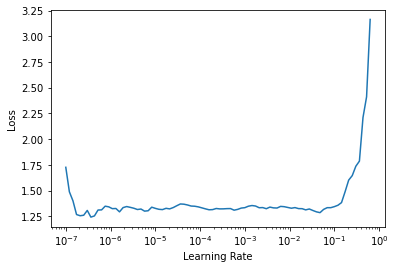

In [26]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.258662,1.008449,0.467890,0.464286,0.613208,00:34
1,1.014730,0.779612,0.507645,0.494975,0.619497,00:34


Better model found at epoch 0 with valid_loss value: 1.0084487199783325.


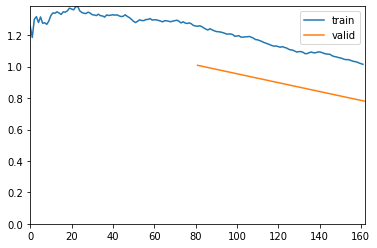

Better model found at epoch 1 with valid_loss value: 0.7796122431755066.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.867449,0.731325,0.512232,0.498807,0.657233,00:36
1,0.862425,0.732905,0.506116,0.493113,0.562893,00:36
2,0.836887,0.978922,0.501529,0.487654,0.496855,00:36
3,0.820800,0.716544,0.553517,0.535714,0.613208,00:36
4,0.778767,0.726870,0.518349,0.504178,0.569182,00:36
5,0.766993,0.707013,0.501529,0.490610,0.657233,00:36
6,0.742704,0.717137,0.490826,0.481572,0.616352,00:36
7,0.734128,0.705046,0.496942,0.480565,0.427673,00:36
8,0.729578,0.701328,0.513761,0.500000,0.575472,00:36
9,0.728507,0.708586,0.510703,0.496183,0.408805,00:36


Better model found at epoch 0 with valid_loss value: 0.7313251495361328.


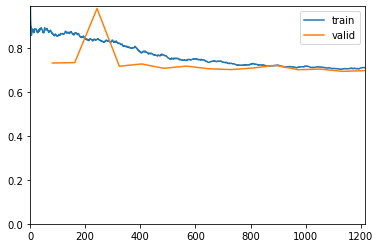

Better model found at epoch 3 with valid_loss value: 0.7165444493293762.
Better model found at epoch 5 with valid_loss value: 0.7070132493972778.
Better model found at epoch 7 with valid_loss value: 0.7050459980964661.
Better model found at epoch 8 with valid_loss value: 0.7013281583786011.
Better model found at epoch 11 with valid_loss value: 0.7007508873939514.
Better model found at epoch 13 with valid_loss value: 0.6932244300842285.


In [27]:
learn.fine_tune(15,freeze_epochs=2)

In [28]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

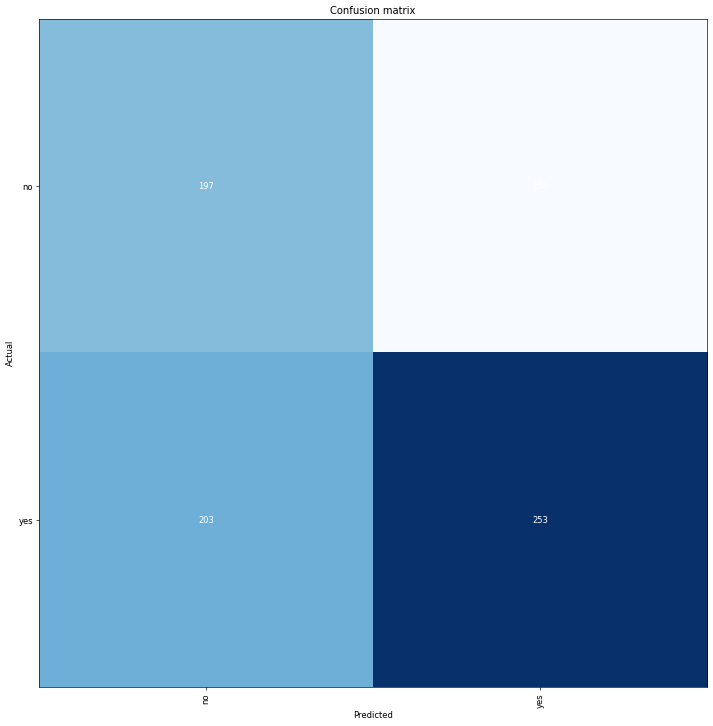

In [29]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [30]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5576208233833313.


(#4) [0.6887688636779785,0.5576208233833313,0.6216216216216216,0.5548245614035088]

## MixUp

In [31]:
mixup=MixUp()
callbacks2 = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18'),
    mixup
]

In [32]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()])

No pretrained weights exist for this model. Using random initialization.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.228515,1.441329,0.513761,0.500000,0.433962,00:43
1,1.041818,1.028575,0.492355,0.450704,0.201258,00:37


Better model found at epoch 0 with valid_loss value: 1.4413293600082397.


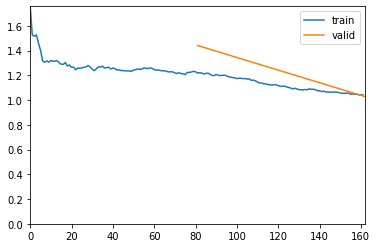

Better model found at epoch 1 with valid_loss value: 1.0285749435424805.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.933135,0.791534,0.478593,0.469333,0.553459,00:45
1,0.869898,0.834046,0.492355,0.486692,0.805031,00:45
2,0.843508,1.153259,0.498471,0.416667,0.078616,00:45
3,0.810952,0.773558,0.474006,0.466667,0.572327,00:37
4,0.783672,0.738985,0.487768,0.468864,0.402516,00:36
5,0.768532,0.790357,0.492355,0.484979,0.710692,00:45
6,0.747749,0.780085,0.493884,0.486653,0.745283,00:36
7,0.746276,0.711803,0.510703,0.491071,0.172956,00:45
8,0.732183,0.700167,0.501529,0.487952,0.509434,00:45
9,0.725528,0.780864,0.498471,0.482639,0.437107,00:45


Better model found at epoch 0 with valid_loss value: 0.7915337681770325.


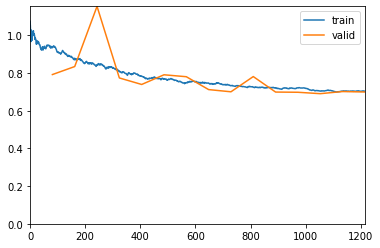

Better model found at epoch 3 with valid_loss value: 0.7735575437545776.
Better model found at epoch 4 with valid_loss value: 0.7389847040176392.
Better model found at epoch 7 with valid_loss value: 0.7118034958839417.
Better model found at epoch 8 with valid_loss value: 0.700167179107666.
Better model found at epoch 10 with valid_loss value: 0.6986996531486511.
Better model found at epoch 11 with valid_loss value: 0.6976264715194702.
Better model found at epoch 12 with valid_loss value: 0.6901854276657104.


In [33]:
learn.fine_tune(15,freeze_epochs=2)

In [34]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

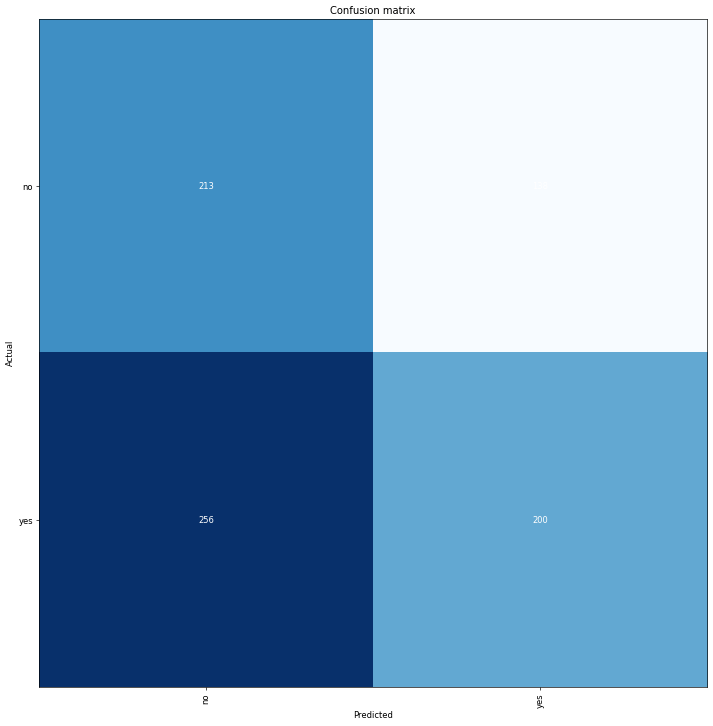

In [35]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [36]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5117719769477844.


(#4) [0.6960843801498413,0.5117719769477844,0.591715976331361,0.43859649122807015]

## Ranger + Flat cosin Anneal

In [37]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

No pretrained weights exist for this model. Using random initialization.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.244235,0.924822,0.490826,0.474916,0.446541,00:43
1,1.261851,0.867112,0.509174,0.495385,0.506289,00:43


Better model found at epoch 0 with valid_loss value: 0.924821674823761.


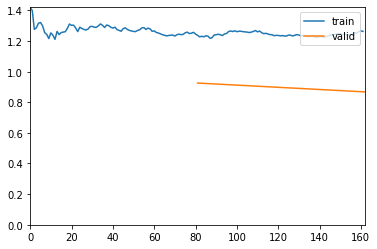

Better model found at epoch 1 with valid_loss value: 0.8671117424964905.


In [38]:
learn.fit_flat_cos(2,lr=1e-3)

In [39]:
learn.unfreeze()

SuggestedLRs(lr_min=1.9054607491852948e-07, lr_steep=7.585775847473997e-07)

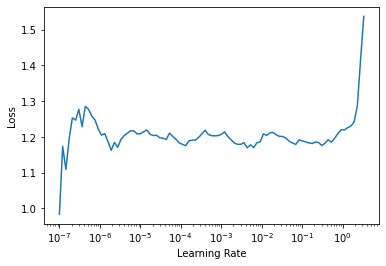

In [40]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.169805,0.885002,0.506116,0.492625,0.525157,00:45
1,1.104030,0.809819,0.498471,0.486339,0.559748,00:44
2,0.958503,0.806483,0.481651,0.475751,0.647799,00:45
3,0.885972,0.736374,0.519878,0.505348,0.594340,00:44
4,0.823025,0.724067,0.474006,0.468750,0.613208,00:43
5,0.795365,0.753914,0.477064,0.471564,0.625786,00:44
6,0.754507,0.724052,0.454128,0.449612,0.547170,00:45
7,0.745273,0.708427,0.487768,0.478149,0.584906,00:45
8,0.732847,0.717517,0.503058,0.491272,0.619497,00:45
9,0.722592,0.704368,0.481651,0.471390,0.544025,00:44


Better model found at epoch 0 with valid_loss value: 0.8850018382072449.


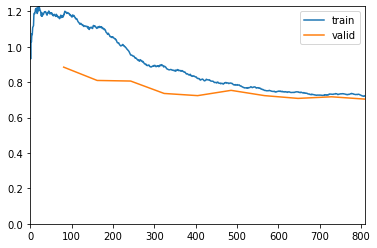

Better model found at epoch 1 with valid_loss value: 0.8098190426826477.
Better model found at epoch 2 with valid_loss value: 0.8064829707145691.
Better model found at epoch 3 with valid_loss value: 0.7363737225532532.
Better model found at epoch 4 with valid_loss value: 0.7240666151046753.
Better model found at epoch 6 with valid_loss value: 0.7240523099899292.
Better model found at epoch 7 with valid_loss value: 0.7084270715713501.
Better model found at epoch 9 with valid_loss value: 0.7043684720993042.


In [41]:
learn.fit_flat_cos(10,lr=1e-2)

In [42]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [43]:
learn.dls = dlsTest

In [44]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.49690210819244385.


(#4) [0.701427161693573,0.49690210819244385,0.5576036866359447,0.5307017543859649]

## Ranger+Flar Cossin Anneal+LabelSmoothing

In [45]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

No pretrained weights exist for this model. Using random initialization.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.252758,0.900011,0.522936,0.508982,0.534591,00:43
1,1.209936,0.898084,0.501529,0.488889,0.553459,00:43


Better model found at epoch 0 with valid_loss value: 0.9000110030174255.


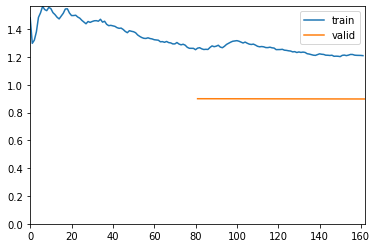

Better model found at epoch 1 with valid_loss value: 0.898083508014679.


In [46]:
learn.fit_flat_cos(2,lr=1e-3)

In [47]:
learn.unfreeze()

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=2.2908675418875646e-06)

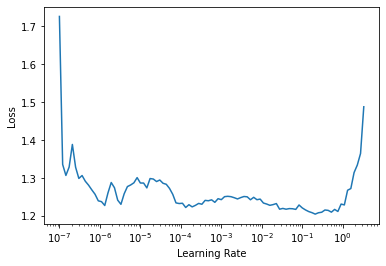

In [48]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.156013,0.840245,0.510703,0.497253,0.569182,00:45
1,1.084617,0.804007,0.525994,0.512121,0.531447,00:45
2,0.966846,0.750470,0.512232,0.498516,0.528302,00:42
3,0.862209,0.749631,0.498471,0.485795,0.537736,00:45
4,0.807357,0.732028,0.506116,0.491909,0.477987,00:43
5,0.781766,0.713054,0.503058,0.490814,0.588050,00:45
6,0.748831,0.698405,0.530581,0.518033,0.496855,00:45
7,0.737712,0.701865,0.512232,0.498567,0.547170,00:45
8,0.729103,0.697616,0.516820,0.503185,0.496855,00:45
9,0.718610,0.701621,0.486239,0.472222,0.481132,00:45


Better model found at epoch 0 with valid_loss value: 0.8402446508407593.


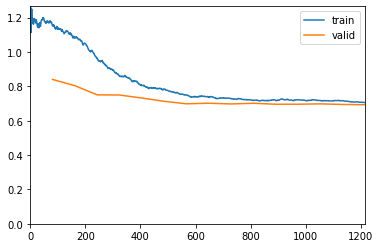

Better model found at epoch 1 with valid_loss value: 0.8040065169334412.
Better model found at epoch 2 with valid_loss value: 0.7504703998565674.
Better model found at epoch 3 with valid_loss value: 0.7496307492256165.
Better model found at epoch 4 with valid_loss value: 0.7320284843444824.
Better model found at epoch 5 with valid_loss value: 0.7130542993545532.
Better model found at epoch 6 with valid_loss value: 0.6984047889709473.
Better model found at epoch 8 with valid_loss value: 0.6976158022880554.
Better model found at epoch 10 with valid_loss value: 0.6958877444267273.
Better model found at epoch 13 with valid_loss value: 0.6945902109146118.
Better model found at epoch 14 with valid_loss value: 0.6930821537971497.


In [49]:
learn.fit_flat_cos(15,lr=1e-2)

In [50]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [51]:
learn.dls = dlsTest

In [52]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.48451054096221924.


(#4) [0.6979413032531738,0.48451054096221924,0.5471698113207547,0.5087719298245614]

## Ranger +Flat + Label + MixUp

In [53]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

No pretrained weights exist for this model. Using random initialization.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.293190,0.934259,0.490826,0.480818,0.591195,00:43
1,1.251168,0.935258,0.470948,0.465174,0.588050,00:43


Better model found at epoch 0 with valid_loss value: 0.9342588782310486.


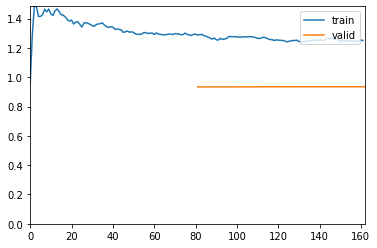

In [54]:
learn.fit_flat_cos(2,lr=1e-3)

In [55]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.194589,0.994957,0.495413,0.483333,0.547170,00:42
1,1.083962,0.848250,0.500000,0.481928,0.377358,00:45
2,0.964674,0.737705,0.524465,0.510638,0.528302,00:45
3,0.878887,0.773068,0.480122,0.473684,0.622642,00:37
4,0.812251,0.742005,0.478593,0.469974,0.566038,00:44
5,0.787093,0.706774,0.518349,0.503958,0.600629,00:45
6,0.748473,0.774715,0.475535,0.452471,0.374214,00:45
7,0.739035,0.707829,0.525994,0.522727,0.289308,00:45
8,0.723885,0.700320,0.496942,0.483582,0.509434,00:44
9,0.717170,0.708702,0.532110,0.526549,0.374214,00:45


Better model found at epoch 0 with valid_loss value: 0.9949573874473572.


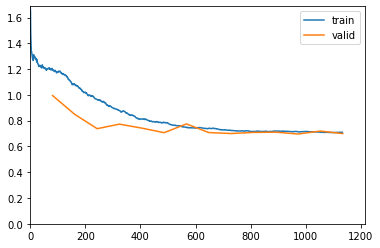

Better model found at epoch 1 with valid_loss value: 0.8482502698898315.
Better model found at epoch 2 with valid_loss value: 0.7377047538757324.
Better model found at epoch 5 with valid_loss value: 0.7067744135856628.
Better model found at epoch 8 with valid_loss value: 0.7003203630447388.
Better model found at epoch 11 with valid_loss value: 0.6963224411010742.
No improvement since epoch 11: early stopping


In [56]:
learn.fit_flat_cos(15,lr=1e-2)

In [57]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

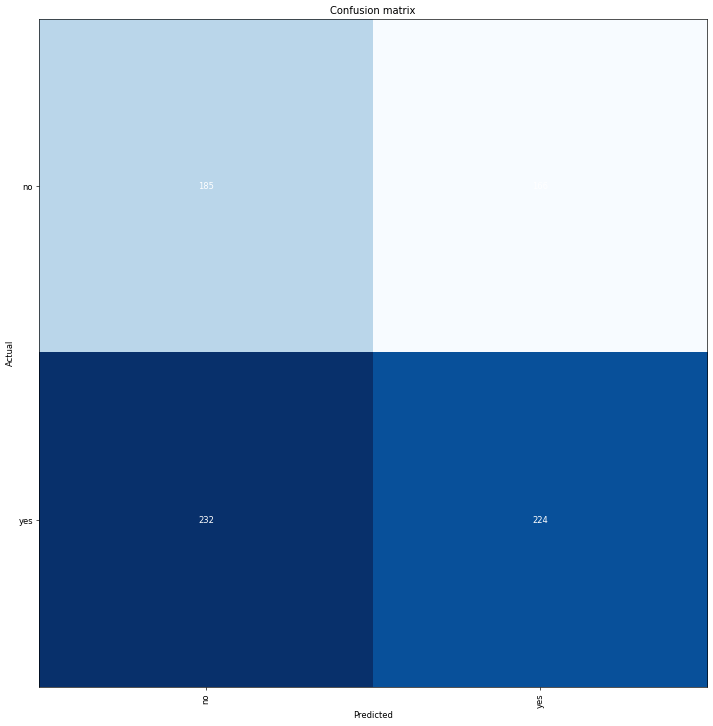

In [58]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [59]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5068153738975525.


(#4) [0.6977203488349915,0.5068153738975525,0.5743589743589743,0.49122807017543857]

## Ranger + Flat + MixUp

In [60]:
mixup=MixUp()
callbacks2 = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18'),
    mixup
]

In [61]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

No pretrained weights exist for this model. Using random initialization.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.281383,1.027945,0.492355,0.482673,0.613208,00:35
1,1.287063,1.006040,0.510703,0.497423,0.606918,00:35


Better model found at epoch 0 with valid_loss value: 1.027944803237915.


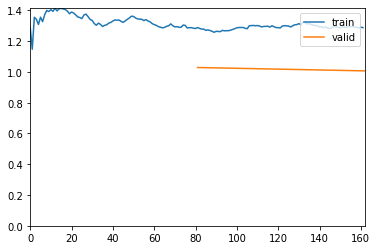

Better model found at epoch 1 with valid_loss value: 1.0060397386550903.


In [62]:
learn.fit_flat_cos(2,lr=1e-3)

In [63]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.209681,0.840084,0.500000,0.488491,0.600629,00:37
1,1.071987,0.844651,0.493884,0.474903,0.386792,00:38
2,0.977514,0.786406,0.495413,0.481366,0.487421,00:38
3,0.860194,0.794231,0.504587,0.493056,0.669811,00:37
4,0.813214,0.780907,0.500000,0.490683,0.745283,00:38
5,0.791646,0.870998,0.518349,0.505263,0.452830,00:37
6,0.745984,0.728844,0.490826,0.476780,0.484277,00:36
7,0.742212,0.710506,0.524465,0.511111,0.506289,00:38
8,0.725816,0.753005,0.525994,0.518018,0.361635,00:37
9,0.723377,0.774740,0.496942,0.473684,0.311321,00:37


Better model found at epoch 0 with valid_loss value: 0.8400838971138.


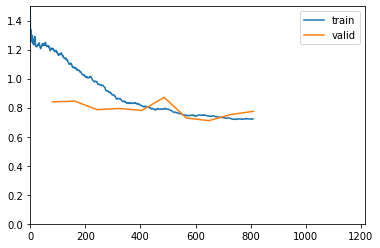

Better model found at epoch 2 with valid_loss value: 0.7864060997962952.
Better model found at epoch 4 with valid_loss value: 0.7809066772460938.
Better model found at epoch 6 with valid_loss value: 0.7288435697555542.
Better model found at epoch 7 with valid_loss value: 0.7105061411857605.
No improvement since epoch 7: early stopping


In [64]:
learn.fit_flat_cos(15,lr=1e-2)

In [65]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [66]:
learn.dls = dlsTest

In [67]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5080544948577881.


(#4) [0.7281708717346191,0.5080544948577881,0.5786666666666667,0.4758771929824561]

## Ranger + MixUp

In [68]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [69]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

No pretrained weights exist for this model. Using random initialization.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.268684,0.975848,0.441896,0.431085,0.462264,00:35
1,1.268755,0.900094,0.481651,0.469208,0.503145,00:35


Better model found at epoch 0 with valid_loss value: 0.9758480787277222.


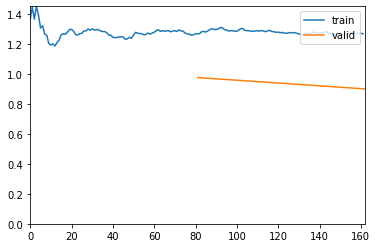

Better model found at epoch 1 with valid_loss value: 0.9000943899154663.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.209538,0.861614,0.507645,0.493827,0.503145,00:38
1,1.217617,0.947192,0.478593,0.468144,0.531447,00:38
2,1.224657,0.954392,0.478593,0.468835,0.544025,00:38
3,1.173294,0.890093,0.490826,0.479339,0.547170,00:38


Better model found at epoch 0 with valid_loss value: 0.8616140484809875.


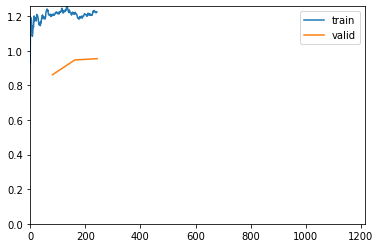

No improvement since epoch 0: early stopping


In [70]:
learn.fine_tune(15,freeze_epochs=2)

In [71]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [72]:
learn.dls = dlsTest

In [73]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5055761933326721.


(#4) [0.8843972086906433,0.5055761933326721,0.574025974025974,0.48464912280701755]

## Faltten + MixUp

In [74]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()])

No pretrained weights exist for this model. Using random initialization.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.058538,0.818715,0.503058,0.491400,0.628931,00:36
1,0.951408,0.756669,0.503058,0.491184,0.613208,00:34


Better model found at epoch 0 with valid_loss value: 0.8187148571014404.


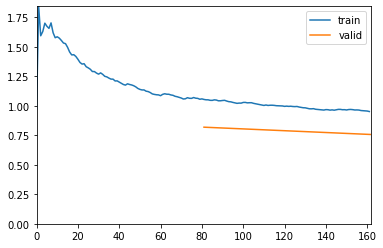

Better model found at epoch 1 with valid_loss value: 0.756668746471405.


In [75]:
learn.fit_flat_cos(2,lr=1e-3)

In [76]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.992746,0.810526,0.533639,0.518841,0.562893,00:37
1,0.961717,2.059597,0.486239,0.474860,0.534591,00:37
2,0.950108,2.519599,0.498471,0.470930,0.254717,00:37
3,0.956636,0.714852,0.483180,0.452381,0.298742,00:36
4,1.077258,136.398163,0.486239,0.486239,1.000000,00:37
5,0.937923,17.928288,0.510703,0.491803,0.188679,00:35
6,0.963945,0.702288,0.487768,0.486043,0.930818,00:35
7,0.928826,0.875327,0.513761,0.500000,0.062893,00:37
8,0.866420,12.019597,0.513761,0.500000,0.298742,00:37
9,0.801808,15.988129,0.507645,0.492754,0.427673,00:37


Better model found at epoch 0 with valid_loss value: 0.8105257749557495.


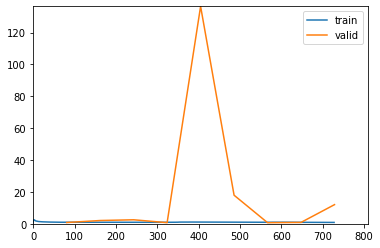

Better model found at epoch 3 with valid_loss value: 0.7148522138595581.
Better model found at epoch 6 with valid_loss value: 0.7022876143455505.
No improvement since epoch 6: early stopping


In [77]:
learn.fit_flat_cos(10,lr=1e-2)

In [78]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [79]:
learn.dls = dlsTest

In [80]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.565055787563324.


(#4) [0.6841373443603516,0.565055787563324,0.5684485006518905,0.956140350877193]

## Ranger + Label

In [81]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [82]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

No pretrained weights exist for this model. Using random initialization.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.258479,1.008797,0.460245,0.449275,0.487421,00:35
1,1.319278,0.898530,0.519878,0.506024,0.528302,00:35


Better model found at epoch 0 with valid_loss value: 1.0087966918945312.


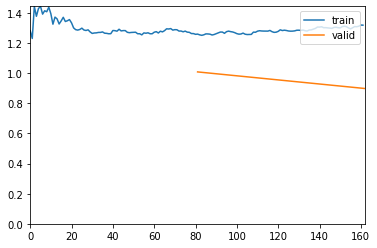

Better model found at epoch 1 with valid_loss value: 0.8985304236412048.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.240025,0.910437,0.516820,0.502924,0.540881,00:37
1,1.224278,0.958872,0.480122,0.468571,0.515723,00:38
2,1.187787,0.913140,0.498471,0.483871,0.471698,00:38
3,1.185572,0.874230,0.525994,0.511696,0.550314,00:38
4,1.179549,0.893222,0.486239,0.470395,0.449686,00:37
5,1.183981,0.914426,0.501529,0.486486,0.452830,00:38
6,1.135954,0.871945,0.480122,0.468391,0.512579,00:37
7,1.106024,0.863566,0.501529,0.487421,0.487421,00:36
8,1.085307,0.843498,0.518349,0.504823,0.493711,00:36
9,1.083112,0.845340,0.487768,0.473520,0.477987,00:38


Better model found at epoch 0 with valid_loss value: 0.9104374647140503.


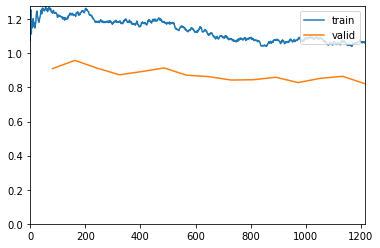

Better model found at epoch 3 with valid_loss value: 0.8742302656173706.
Better model found at epoch 6 with valid_loss value: 0.871944785118103.
Better model found at epoch 7 with valid_loss value: 0.8635661602020264.
Better model found at epoch 8 with valid_loss value: 0.8434978127479553.
Better model found at epoch 11 with valid_loss value: 0.8287145495414734.
Better model found at epoch 14 with valid_loss value: 0.8217143416404724.


In [83]:
learn.fine_tune(15,freeze_epochs=2)

In [84]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [85]:
learn.dls = dlsTest

In [86]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.4857496917247772.


(#4) [0.850878119468689,0.4857496917247772,0.545054945054945,0.543859649122807]

## Faltten + Label

In [87]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

No pretrained weights exist for this model. Using random initialization.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.115108,0.891972,0.522936,0.508475,0.566038,00:32
1,0.988674,0.742250,0.513761,0.500000,0.487421,00:35


Better model found at epoch 0 with valid_loss value: 0.8919719457626343.


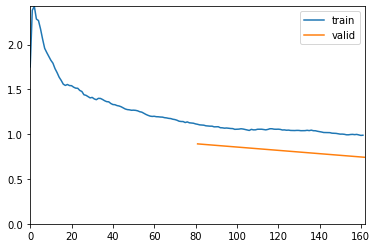

Better model found at epoch 1 with valid_loss value: 0.7422497272491455.


In [88]:
learn.fit_flat_cos(2,lr=1e-3)

In [89]:
learn.unfreeze()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=9.12010818865383e-07)

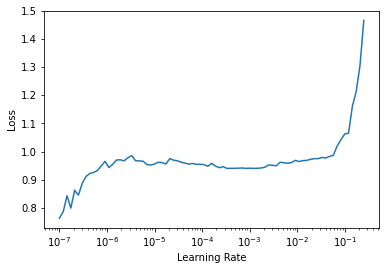

In [90]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.022628,0.923548,0.490826,0.483146,0.676101,00:37
1,0.939815,0.719947,0.498471,0.491554,0.915094,00:37
2,0.917661,0.810307,0.500000,0.488127,0.581761,00:37
3,0.960200,0.721632,0.492355,0.487037,0.827044,00:37
4,0.914533,1.557803,0.533639,0.512770,0.820755,00:37


Better model found at epoch 0 with valid_loss value: 0.9235477447509766.


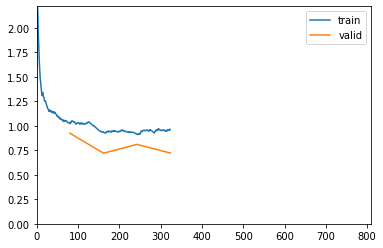

Better model found at epoch 1 with valid_loss value: 0.7199465036392212.
No improvement since epoch 1: early stopping


In [91]:
learn.fit_flat_cos(10,lr=1e-2)

In [92]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [93]:
learn.dls = dlsTest

In [94]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5613383054733276.


(#4) [0.7032206654548645,0.5613383054733276,0.5681818181818182,0.9320175438596491]

## Label + MixUp

In [95]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

No pretrained weights exist for this model. Using random initialization.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.203687,1.271548,0.503058,0.486989,0.411950,00:35
1,1.009626,1.088595,0.481651,0.481283,0.849057,00:34


Better model found at epoch 0 with valid_loss value: 1.2715480327606201.


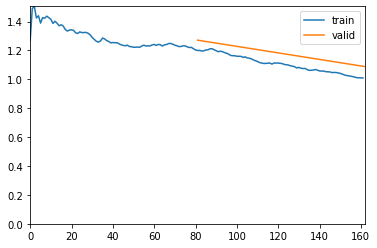

Better model found at epoch 1 with valid_loss value: 1.0885950326919556.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.866908,0.750278,0.510703,0.496689,0.471698,00:37
1,0.857271,0.725165,0.547401,0.533951,0.544025,00:37
2,0.838361,0.758353,0.515290,0.501040,0.757862,00:37
3,0.803302,0.741811,0.512232,0.498054,0.402516,00:37
4,0.781295,0.808610,0.507645,0.490099,0.311321,00:37


Better model found at epoch 0 with valid_loss value: 0.7502777576446533.


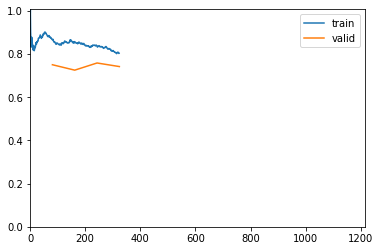

Better model found at epoch 1 with valid_loss value: 0.7251653671264648.
No improvement since epoch 1: early stopping


In [96]:
learn.fine_tune(15,freeze_epochs=2)

In [97]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [98]:
learn.dls = dlsTest

In [99]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.524163544178009.


(#4) [0.7360334396362305,0.524163544178009,0.5942408376963351,0.49780701754385964]